In [32]:
%%time
import pandas as pd
import numpy as np
# df = pd.read_csv('HMAHCC_COMP.csv')

Wall time: 0 ns


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

#### Summary
1. 'PAY_DAY_SUPPLY_CNT' and 'PAYABLE_QTY' are better variables than dozens of features of brand names.

>I built two sets of features and ran Logistic Regression and RF on them. 

>First set contains 65 columns, each column represents one brand name, and each entry represent total opioid consumed (product of MME and PAY_DAY_SUPPLY_CNT for day 0 and before). 

>Second set contains 6 columns, including SUPPLY_CNT_on_day0, PAYABLE_QTY_on_day0, MME_on_day0, total_PAYABLE_QTY_prior, total_SUPPLY_CNT_prior, avg_MME_prior, max_MME_prior. 

>The accuracy rate of RF and Logistic Regression is c. 0.80 on second set, higher than 0.73 on first set. 

2. 'MME' might not be as important as I imagine at the beginning. Based on RF importance scores, 'PAY_DAY_SUPPLY_CNT' and 'PAYABLE_QTY' are much more important than 'MME'.

#### Next Step
1. Combine features created by Chris and run some models to see which features works the best together.
2. Try other models on my features. 

In [3]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)

In [4]:
rx_paid = df[df['event_descr']=='RX Claim - Paid']

rx_paid = rx_paid.drop(['event_attr2',
                        'event_attr7'],
                         axis = 1)

rx_paid.columns = ['id',
                   'event_descr',
                   'gpi_drug_class_description',
                   'rx_cost',
                   'net_paid_amount',
                   'brand_name',
                   'drug_group_description',
                   'generic_name',
                   'member_responsible_amount',
                   'gpi_drug_group8_id',
                   'Days',
                   'PAY_DAY_SUPPLY_CNT',
                   'PAYABLE_QTY',
                   'MME',
                   'DRUG_TYPE',
                   'Specialty',
                   'Specialty2',
                   'Specialty3']

#### Read in Chris's response variables

In [5]:
response_variable = pd.read_csv('response_variable_v2.csv')

In [6]:
response_variable.head()

,id,naive,LTOT_v2
0,ID10010854159,"[0, 706]",False
1,ID10013863216,[0],True
2,ID10024447278,[0],True
3,ID1002482139,[0],True
4,ID1003386406,[0],False


In [7]:
response_variable['LTOT_v2'].value_counts()

False    7056
True     6892
Name: LTOT_v2, dtype: int64

#### Get opioid-only rx_paid  dataframe

In [8]:
opioid_col = ['id',
              'gpi_drug_class_description',
              'brand_name',
              'drug_group_description',
              'generic_name',
              'gpi_drug_group8_id',
              'PAY_DAY_SUPPLY_CNT',
              'PAYABLE_QTY',
              'MME',
              'Specialty',
              'Specialty2',
              'Specialty3',
              'Days']

opioid = rx_paid[(rx_paid['PAY_DAY_SUPPLY_CNT'].notnull())&(rx_paid['Days']<=0)][opioid_col]

#### Note: only 65 brand_name and 162 generic_name for data before day 0
Need to check hold_out data is the same

In [9]:
len(opioid['brand_name'].value_counts())

65

In [10]:
len(opioid['generic_name'].value_counts())

162

#### Take a look at MME in dataframe opioid

In [18]:
opioid.head()

,id,gpi_drug_class_description,brand_name,drug_group_description,generic_name,gpi_drug_group8_id,PAY_DAY_SUPPLY_CNT,PAYABLE_QTY,MME,Specialty,Specialty2,Specialty3,Days
194,ID10010854159,OPIOID AGONISTS,TRAMADOL HCL,PAIN,TRAMADOL HCL TAB 50 MG,65100095.0,5.0,15.0,15.0,Internal Medicine Critical Care Medicine,Hospitalist,Family Practice,0
397,ID10013863216,OPIOID AGONISTS,TRAMADOL HCL,PAIN,TRAMADOL HCL TAB 50 MG,65100095.0,90.0,180.0,10.0,Family Practice,Family Practice Adult Medicine,NaN,0
507,ID10024447278,OPIOID COMBINATIONS,OXYCODONE/ACETAMINOPHEN,PAIN,OXYCODONE W/ ACETAMINOPHEN TAB 5-325 MG,65990002.0,5.0,10.0,15.0,Emergency,Internal Medicine,Pediatrics,-614
512,ID10024447278,OPIOID COMBINATIONS,OXYCODONE/ACETAMINOPHEN,PAIN,OXYCODONE W/ ACETAMINOPHEN TAB 5-325 MG,65990002.0,5.0,15.0,22.5,Emergency,Internal Medicine,Pediatrics,-609
517,ID10024447278,OPIOID COMBINATIONS,OXYCODONE/ACETAMINOPHEN,PAIN,OXYCODONE W/ ACETAMINOPHEN TAB 5-325 MG,65990002.0,5.0,15.0,22.5,Emergency,Internal Medicine,Pediatrics,-575


#### To check the relationship between MME, PAYABLE_QTY, PAY_DAY_SUPPLY_CNT and generic_name

In [19]:
sec2 = opioid.groupby(by='brand_name')
group = sec2.get_group('OXYCODONE/ACETAMINOPHEN')

In [20]:
group[['generic_name', 'PAY_DAY_SUPPLY_CNT','PAYABLE_QTY', 'MME']].sort_values(['generic_name', 'PAYABLE_QTY', 'MME'])

,generic_name,PAY_DAY_SUPPLY_CNT,PAYABLE_QTY,MME
2539516,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,1.0,15.000000
3520926,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,2.0,30.000000
3520749,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,4.0,60.000000
3520754,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,4.0,60.000000
3520778,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,4.0,60.000000
3675570,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,4.0,60.000000
5544074,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,1.0,4.0,60.000000
484293,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,2.0,8.0,60.000000
552457,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,2.0,8.0,60.000000
590018,OXYCODONE W/ ACETAMINOPHEN TAB 10-325 MG,2.0,8.0,60.000000


#### Conclusion for now:
1. The MME in the data is actually the amount of opioid a patient should take per day per prescription.

2. And total amount of opioid a patient take per prescription is MME*PAY_DAY_SUPPLY_CNT

#### Some thoughts about features
I feel like frequency is more important than max usage for a single prescription. 

For example, a patient who used 30 days of low-dose opioids is more likely to go LTOT than a patient used high-dose opioids for one time.

I'm thinking about building 2 or 3 different features and run a simple model on it and see which features doed better.

## Building features

#### Note: there are 102 ppl (0.73% of data) who don't have any PAY_DAY_SUPPLY_CNT and MME data, do we count it as False sample?
#### Fix this later: There are some rows has PAY_DAY_SUPPLY_CNT but no MME

In [21]:
print('PAY_DAY_SUPPLY_CNT not null', opioid.shape, ' id len',  len(opioid['id'].value_counts()))

opioid2 = rx_paid[(rx_paid['MME'].notnull())&(rx_paid['Days']<=0)][opioid_col]
print('MME not null', opioid2.shape, ' id len', len(opioid2['id'].value_counts()))

# rx_paid[(rx_paid['MME'].isnull())&(rx_paid['PAY_DAY_SUPPLY_CNT'].notnull())]

PAY_DAY_SUPPLY_CNT not null (91635, 13)  id len 13898
MME not null (91136, 13)  id len 13898


In [22]:
rx_paid[(rx_paid['MME'].notnull())&(rx_paid['PAY_DAY_SUPPLY_CNT'].isnull())]

,id,event_descr,gpi_drug_class_description,rx_cost,net_paid_amount,brand_name,drug_group_description,generic_name,member_responsible_amount,gpi_drug_group8_id,Days,PAY_DAY_SUPPLY_CNT,PAYABLE_QTY,MME,DRUG_TYPE,Specialty,Specialty2,Specialty3


In [23]:
opioid2_grouped = opioid.groupby(by=['id'])

In [24]:
opioid2_grouped.get_group('ID78674772139')

,id,gpi_drug_class_description,brand_name,drug_group_description,generic_name,gpi_drug_group8_id,PAY_DAY_SUPPLY_CNT,PAYABLE_QTY,MME,Specialty,Specialty2,Specialty3,Days
4597772,ID78674772139,OPIOID AGONISTS,OXYMORPHONE HYDROCHLORIDE,PAIN,OXYMORPHONE HCL TAB SR 12HR 30 MG,65100080.0,28.0,84.0,270.0,Psychiatry & Neurology,Pain Medicine Pain Management,Physical Medicine & Rehab Pain Medicine,-916
4597774,ID78674772139,OPIOID AGONISTS,OXYCODONE HCL,PAIN,OXYCODONE HCL TAB 30 MG,65100075.0,28.0,112.0,180.0,Psychiatry & Neurology,Pain Medicine Pain Management,Physical Medicine & Rehab Pain Medicine,-908
4597785,ID78674772139,OPIOID AGONISTS,OXYCODONE HCL,PAIN,OXYCODONE HCL TAB 30 MG,65100075.0,28.0,112.0,180.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-881
4597786,ID78674772139,OPIOID AGONISTS,OXYMORPHONE HYDROCHLORIDE,PAIN,OXYMORPHONE HCL TAB SR 12HR 30 MG,65100080.0,28.0,84.0,270.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-881
4597794,ID78674772139,OPIOID AGONISTS,OXYMORPHONE HYDROCHLORIDE,PAIN,OXYMORPHONE HCL TAB SR 12HR 30 MG,65100080.0,28.0,56.0,180.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-855
4597795,ID78674772139,OPIOID AGONISTS,OXYCODONE HCL,PAIN,OXYCODONE HCL TAB 30 MG,65100075.0,28.0,168.0,270.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-855
4597800,ID78674772139,OPIOID AGONISTS,OXYMORPHONE HYDROCHLORIDE,PAIN,OXYMORPHONE HCL TAB SR 12HR 30 MG,65100080.0,28.0,56.0,180.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-827
4597801,ID78674772139,OPIOID AGONISTS,OXYCODONE HCL,PAIN,OXYCODONE HCL TAB 30 MG,65100075.0,28.0,168.0,270.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-827
4597804,ID78674772139,OPIOID AGONISTS,OXYMORPHONE HYDROCHLORIDE,PAIN,OXYMORPHONE HCL TAB SR 12HR 30 MG,65100080.0,28.0,56.0,180.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-799
4597805,ID78674772139,OPIOID AGONISTS,OXYCODONE HCL,PAIN,OXYCODONE HCL TAB 30 MG,65100075.0,28.0,168.0,270.0,Physician Assistant,Family Practice,Clinical Nurse Specialist Critical Care,-799


In [25]:
idtestlist = list(opioid2['id'].value_counts().index)

In [180]:
%%time
def product_sum(df):
    return(df['MME'].values.dot(df['PAY_DAY_SUPPLY_CNT'].values))

# ID = 'ID78674772139'

features = pd.DataFrame()
for ID in idtestlist:
    tmp = opioid2_grouped.get_group(ID)
    output = pd.DataFrame(tmp.groupby(by='brand_name')['MME','PAY_DAY_SUPPLY_CNT'].agg(product_sum)).T
    output = output.iloc[0:1,:]
    output.index = [ID]
    # features = pd.concat([output, features], axis=1, sort=False)
    features = features.append(output, sort=False)

Wall time: 3min 2s


In [27]:
features = features.fillna(0)
features.to_csv('features_matthew.csv')
features.head()

In [28]:
# features = pd.read_csv('features_matthew.csv', index_col=0)
# features.shape

(13898, 65)

#### A little bit exploratory analysis on features

In [29]:
import numpy as np
def count_nonzero(se):
    return(np.sum(se.values != 0))

In [30]:
brands_used = features.T.apply(count_nonzero)

In [31]:
# 8757 patients (62.55%) used only 1 brand 
brands_used.value_counts()

1     8757
2     3315
3     1194
4      410
5      145
6       45
7       18
8       11
9        2
12       1
dtype: int64

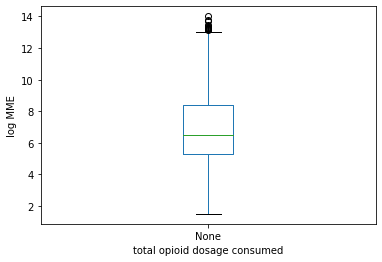

In [33]:
MME_used = features.T.apply(np.sum)
MME_used_log = np.log(MME_used)
MME_used_log.plot.box()
plt.ylabel('log MME')
plt.xlabel('total opioid dosage consumed')
plt.show()

#### Merge response_variable and features

In [34]:
df2 = response_variable[['id', 'LTOT_v2']].merge(features, left_on='id', right_on=features.index)
df2 = df2.set_index('id')

#### Build models on features

In [35]:
df2['LTOT_v2'].value_counts()

False    7007
True     6873
Name: LTOT_v2, dtype: int64

In [36]:
# Base line
df2['LTOT_v2'].value_counts()[False]/sum(df2['LTOT_v2'].value_counts())

0.5048270893371758

In [37]:
from sklearn.model_selection import train_test_split
X = df2.iloc[:,1:]
y = df2.iloc[:,0].map(lambda x: 1 if x == True else 0 )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

#### Logistic

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

yhead_train = logit_model.predict(X_train)
print('train acuracy', accuracy_score(y_train, yhead_train))
print('train roc_auc', roc_auc_score(y_train, yhead_train))

yhead_test = logit_model.predict(X_test)
print('test acuracy', accuracy_score(y_test, yhead_test))
print('test roc_auc', roc_auc_score(y_test, yhead_test))

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


train acuracy 0.7397701643217699
train roc_auc 0.73878008009976
test acuracy 0.7314148681055156
test roc_auc 0.731400216952318


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Random Forest

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

rf_model = RandomForestClassifier(n_estimators=100, max_depth=3,
                                  random_state=100)

cv_results = cross_validate(rf_model, X_train, y_train, cv=3,
                            scoring= 'accuracy',
                            return_train_score=True)

cv_results['test_score']

{'fit_time': array([0.13766265, 0.13356304, 0.13618827]),
 'score_time': array([0.01795387, 0.01894712, 0.01798868]),
 'test_score': array([0.74097938, 0.7445232 , 0.74250725]),
 'train_score': array([0.75398743, 0.75028194, 0.75032216])}

#### Look at better parameter on RF

In [ ]:
# parameters = {'n_estimators':list(range(100,2100,100)),
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'min_samples_split': [2, 5, 10],
#                 'min_samples_leaf': [1, 2, 4],
#              'max_features': ['auto', 'sqrt']}

In [67]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': list(range(1,31,1))}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, parameters, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

rf_grid.best_params_

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\l

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\l

Wall time: 3.68 s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

#### To visualize the effect of different hyperparameters of RF

In [64]:
%%time
grid = list(range(1,31,1))
train_accuracy = list()
test_accuracy = list()
for i in grid:
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=i,
                                      random_state=0)
    cv_results = cross_validate(rf_model, X_train, y_train, cv=3,
                            scoring= 'accuracy',
                            return_train_score=True)

    train_accuracy.append(np.mean(cv_results['train_score']))
    test_accuracy.append(np.mean(cv_results['test_score']))

test_res = pd.DataFrame([train_accuracy, test_accuracy], index = ['train_accuracy', 'test_accuracy']).T
test_res.set_index = grid
test_res.plot()
plt.ylabel('Accuracy')
plt.xlabel('max_depth')

Wall time: 33.9 s


## Build second set of features

In [166]:
%%time

features3 = pd.DataFrame()
for ID in idtestlist:
    tmp = opioid2_grouped.get_group(ID)

    # MME (per day) on day 0
    # Suuply_CNT on day 0
    on_day0 = tmp[tmp['Days'] == 0] 
    if not on_day0.empty:
        MME0 = on_day0['MME'].values[0]
        SC0 = on_day0['PAY_DAY_SUPPLY_CNT'].values[0]
        PQ0 = on_day0['PAYABLE_QTY'].values[0]
    else:
        MME0 = 0
        SC0 = 0
        PQ0 = 0

    # max MME (per day) prior to day 0
    # average MME (per day) prior to day 0
    # Total Supply_CNT prior to day 0
    prior_day0 = tmp[tmp['Days'] < 0]
    if not prior_day0.empty:
        maxMME = np.nanmax(prior_day0['MME'].values)
        avgMME = np.nanmean(prior_day0['MME'].values)
        totalSC = np.sum(prior_day0['PAY_DAY_SUPPLY_CNT'].values)
        totalPQ = np.sum(prior_day0['PAYABLE_QTY'].values)
    else:
        maxMME = 0
        avgMME = 0
        totalSC = 0
        totalPQ = 0

    output = pd.DataFrame({'MME_on_day0': MME0, 
                         'SUPPLY_CNT_on_day0': SC0,
                           'PAYABLE_QTY_on_day0': PQ0,
                         'max_MME_prior': maxMME,
                         'avg_MME_prior': avgMME,
                         'total_SUPPLY_CNT_prior': totalSC,
                          'total_PAYABLE_QTY_prior': totalPQ},
                          index = [ID])

    features3 = features3.append(output, sort=False)

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


Wall time: 47 s


#### Combine w/ response variables

In [167]:
df4 = response_variable[['id', 'LTOT_v2']].merge(features3, left_on='id', right_on=features3.index)
df4 = df4.set_index('id')
df4.head()

,LTOT_v2,MME_on_day0,SUPPLY_CNT_on_day0,PAYABLE_QTY_on_day0,max_MME_prior,avg_MME_prior,total_SUPPLY_CNT_prior,total_PAYABLE_QTY_prior
id,,,,,,,,
ID10010854159,False,15.0,5.0,15.0,0.0,0.000000,0.0,0.0
ID10013863216,True,10.0,90.0,180.0,0.0,0.000000,0.0,0.0
ID10024447278,True,50.0,3.0,20.0,22.5,20.000000,15.0,40.0
ID1002482139,True,60.0,30.0,120.0,90.0,37.254464,789.0,2895.0
ID1003386406,False,20.0,15.0,60.0,50.0,50.000000,3.0,20.0


In [170]:
X = df4.iloc[:,1:]
y = df4.iloc[:,0].map(lambda x: 1 if x == True else 0 )

#### Deal with nan values in MME data
Some drugs have no MME data, here I fill them with median values of respective columns

In [171]:
X.apply(lambda x: sum(x.isnull()))

MME_on_day0                 2
SUPPLY_CNT_on_day0          0
PAYABLE_QTY_on_day0         0
max_MME_prior              12
avg_MME_prior              12
total_SUPPLY_CNT_prior      0
total_PAYABLE_QTY_prior     0
dtype: int64

In [172]:
X['MME_on_day0'] = X['MME_on_day0'].fillna(np.nanmedian(X['MME_on_day0']))
X['max_MME_prior'] = X['max_MME_prior'].fillna(np.nanmedian(X['max_MME_prior']))
X['avg_MME_prior'] = X['avg_MME_prior'].fillna(np.nanmedian(X['avg_MME_prior']))

In [173]:
X.apply(lambda x: sum(x.isnull()))

MME_on_day0                0
SUPPLY_CNT_on_day0         0
PAYABLE_QTY_on_day0        0
max_MME_prior              0
avg_MME_prior              0
total_SUPPLY_CNT_prior     0
total_PAYABLE_QTY_prior    0
dtype: int64

In [183]:
X.to_csv('features_matthew_v2.csv')

#### Split train and testm

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=33)

#### Logistic regression on second set

In [175]:
%%time

logit_model = LogisticRegression()

cv_results = cross_validate(logit_model, X_train, y_train, cv=3,
                            scoring= 'accuracy',
                            return_train_score=True)

np.mean(cv_results['test_score'])

Wall time: 104 ms


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8027057218211398

#### RF on second set

In [178]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, max_depth=7,
                                  random_state=100)

cv_results = cross_validate(rf_model, X_train, y_train, cv=3,
                            scoring= 'accuracy',
                            return_train_score=True,
                           return_estimator =True)

np.mean(cv_results['test_score'])

Wall time: 997 ms


0.8093648702674389

#### CV of RF on max_depth

In [177]:
%%time
parameters = {'max_depth': list(range(1,31,1))}
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, parameters, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

rf_grid.best_params_

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\l

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\l

Wall time: 3.93 s


C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'max_depth': 7}

#### RF features importance

In [179]:
for idx,estimator in enumerate(cv_results['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                         importance
SUPPLY_CNT_on_day0         0.375082
total_SUPPLY_CNT_prior     0.194985
PAYABLE_QTY_on_day0        0.151859
total_PAYABLE_QTY_prior    0.146904
MME_on_day0                0.053727
avg_MME_prior              0.045509
max_MME_prior              0.031934
Features sorted by their score for estimator 1:
                         importance
SUPPLY_CNT_on_day0         0.390627
total_SUPPLY_CNT_prior     0.180530
PAYABLE_QTY_on_day0        0.157493
total_PAYABLE_QTY_prior    0.143973
avg_MME_prior              0.049545
MME_on_day0                0.043473
max_MME_prior              0.034358
Features sorted by their score for estimator 2:
                         importance
SUPPLY_CNT_on_day0         0.378894
total_SUPPLY_CNT_prior     0.177325
PAYABLE_QTY_on_day0        0.170475
total_PAYABLE_QTY_prior    0.144991
avg_MME_prior              0.050759
MME_on_day0                0.046796
max_MME_prior              0

Wall time: 39.8 s


Text(0.5, 0, 'max_depth')

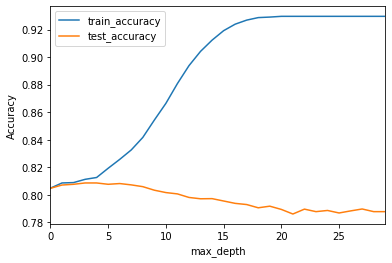

In [150]:
# %%time
# grid = list(range(1,31,1))
# train_accuracy = list()
# test_accuracy = list()
# for i in grid:
#     rf_model = RandomForestClassifier(n_estimators=100, max_depth=i,
#                                       random_state=0)
#     cv_results = cross_validate(rf_model, X_train, y_train, cv=3,
#                             scoring= 'accuracy',
#                             return_train_score=True)

#     train_accuracy.append(np.mean(cv_results['train_score']))
#     test_accuracy.append(np.mean(cv_results['test_score']))

# test_res = pd.DataFrame([train_accuracy, test_accuracy], index = ['train_accuracy', 'test_accuracy']).T
# test_res.set_index = grid
# test_res.plot()
# plt.ylabel('Accuracy')
# plt.xlabel('max_depth')

## Test KNN classifier

In [49]:
response_variable = pd.read_csv('response_variable_v2.csv')
response_variable = response_variable.iloc[:,[0,2]]
features = pd.read_csv('features_matthew_v2.csv', index_col=0)
df = response_variable.merge(features, left_on='id', right_on=features.index.values)
df = df.set_index('id')
df.head()

,LTOT_v2,MME_on_day0,SUPPLY_CNT_on_day0,PAYABLE_QTY_on_day0,max_MME_prior,avg_MME_prior,total_SUPPLY_CNT_prior,total_PAYABLE_QTY_prior
id,,,,,,,,
ID10010854159,False,15.0,5.0,15.0,0.0,0.000000,0.0,0.0
ID10013863216,True,10.0,90.0,180.0,0.0,0.000000,0.0,0.0
ID10024447278,True,50.0,3.0,20.0,22.5,20.000000,15.0,40.0
ID1002482139,True,60.0,30.0,120.0,90.0,37.254464,789.0,2895.0
ID1003386406,False,20.0,15.0,60.0,50.0,50.000000,3.0,20.0


In [50]:
from sklearn.model_selection import train_test_split
X = df.iloc[:,1:]
X = X[['SUPPLY_CNT_on_day0', 'PAYABLE_QTY_on_day0', 'total_SUPPLY_CNT_prior', 'total_PAYABLE_QTY_prior']]
y = df.iloc[:,0].map(lambda x: 1 if x == True else 0 )

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X)
# X2 = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.33, random_state=33)

In [51]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

neigh = KNeighborsClassifier(n_neighbors=135)

cv_results = cross_validate(neigh, X_train, y_train, cv=3,
                            scoring= 'accuracy',
                            return_train_score=True,
                           return_estimator =True)

np.mean(cv_results['test_score'])

Wall time: 3.7 s


0.807324146181558

In [52]:
%%time
from sklearn.model_selection import GridSearchCV

parameters = {'n_neighbors': list(range(5,205,10))}
neigh = KNeighborsClassifier()
neigh_grid = GridSearchCV(neigh, parameters, scoring='roc_auc')
neigh_grid.fit(X_train, y_train)

neigh_grid.best_params_

C:\Users\spong\Anaconda3\envs\test\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 12 s


{'n_neighbors': 135}